# Smooth Vector Field Fitting with Regularization

This notebook builds a simple, reproducible pipeline to **fit a vector field** from noisy samples using a **linear combination of smooth basis fields** with **ridge/Tikhonov regularization**. It uses low-frequency Fourier bases and supports extension to Helmholtz-type bases (gradient + stream) for divergence-free/curl-free modeling.


In [1]:

import numpy as np
import matplotlib.pyplot as plt
from dataclasses import dataclass
from typing import Tuple, List, Optional

np.random.seed(42)


## 1. Generate synthetic noisy vector field

We generate a smooth target field on the unit square as a sum of:
- A **rotational (spiral-like)** component
- A **radial** component with smooth taper
We then add Gaussian noise to simulate measurements.


In [3]:

def make_grid(n: int = 50) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    x = np.linspace(0.0, 1.0, n)
    y = np.linspace(0.0, 1.0, n)
    X, Y = np.meshgrid(x, y, indexing='xy')
    XY = np.stack([X.ravel(), Y.ravel()], axis=1)
    return X, Y, XY

def smooth_radial(X, Y, cx=0.5, cy=0.5):
    r = np.sqrt((X-cx)**2 + (Y-cy)**2) + 1e-12
    # outward radial with Gaussian taper
    ux = (X-cx) * np.exp(-(r/0.35)**2)
    uy = (Y-cy) * np.exp(-(r/0.35)**2)
    return ux, uy

def smooth_spiral(X, Y, cx=0.5, cy=0.5, twist=2.0):
    dx = X-cx
    dy = Y-cy
    r2 = dx*dx + dy*dy
    # rotate by 90 degrees and scale with smooth envelope
    ux = -dy * np.exp(-3*r2) * (1 + twist*r2)
    uy =  dx * np.exp(-3*r2) * (1 + twist*r2)
    return ux, uy

def add_noise(U, V, sigma=0.05):
    return U + sigma*np.random.randn(*U.shape), V + sigma*np.random.randn(*V.shape)

# build dataset
N = 60
X, Y, XY = make_grid(N)
Ur, Vr = smooth_radial(X,Y)
Us, Vs = smooth_spiral(X,Y, twist=3.0)

# true combination
w_r, w_s = 0.7, 1.3
U_true = w_r*Ur + w_s*Us
V_true = w_r*Vr + w_s*Vs

# noisy observations at all grid points (you can subsample later)
U_noisy, V_noisy = add_noise(U_true, V_true, sigma=0.06)

# Save small dataset for reuse with other tools
np.savez('/Users/rishabhkumar/spiral-chirals/vector_field_data_small.npz', 
         X=X, Y=Y, U_true=U_true, V_true=V_true, U_noisy=U_noisy, V_noisy=V_noisy)
print("Saved dataset to /Users/rishabhkumar/spiral-chirals/vector_field_data_small.npz")


Saved dataset to /Users/rishabhkumar/spiral-chirals/vector_field_data_small.npz


## 2. Smooth basis: low-frequency Fourier modes

We use 2D Fourier modes with small wavenumbers for smoothness. Each basis produces a **vector** by giving separate coefficients for \(u\) and \(v\).


In [4]:

def fourier_basis_2d(X, Y, kmax: int = 3) -> np.ndarray:
    """Return Phi of shape [n_points, n_features]
    Features include 1, cos(2πkx), sin(2πkx), cos(2πly), sin(2πly),
    and separable products cos/sin in x with cos/sin in y up to kmax.
    """
    npts = X.size
    x = X.ravel()
    y = Y.ravel()
    feats = [np.ones_like(x)]
    # 1D modes
    for k in range(1, kmax+1):
        feats.append(np.cos(2*np.pi*k*x))
        feats.append(np.sin(2*np.pi*k*x))
        feats.append(np.cos(2*np.pi*k*y))
        feats.append(np.sin(2*np.pi*k*y))
    # separable products
    for kx in range(1, kmax+1):
        for ky in range(1, kmax+1):
            cx = np.cos(2*np.pi*kx*x); sx = np.sin(2*np.pi*kx*x)
            cy = np.cos(2*np.pi*ky*y); sy = np.sin(2*np.pi*ky*y)
            feats += [cx*cy, cx*sy, sx*cy, sx*sy]
    Phi = np.stack(feats, axis=1)
    return Phi  # [npts, nphi]

Phi = fourier_basis_2d(X, Y, kmax=3)
Phi.shape


(3600, 49)

## 3. Ridge/Tikhonov fit with spectral smoothing

We fit coefficients \(a\) and \(b\) such that
\[
u \approx \Phi a,\quad v \approx \Phi b.
\]
To favor smoothness, we penalize higher-frequency coefficients more by using a diagonal matrix \(R\) with weights that grow with wavenumber.


In [5]:

def fourier_penalty(Phi: np.ndarray, kmax: int) -> np.ndarray:
    """Construct diagonal spectral penalty R for the features in fourier_basis_2d.
    We assign small weights to DC/low-frequency terms and larger weights to higher modes.
    The layout must match fourier_basis_2d.
    """
    weights = []
    # DC term
    weights.append(0.0)
    # 1D bands
    for k in range(1, kmax+1):
        w = (k**2)
        weights += [w, w, w, w]
    # separable products
    for kx in range(1, kmax+1):
        for ky in range(1, kmax+1):
            w = (kx**2 + ky**2)
            weights += [w, w, w, w]
    return np.array(weights, dtype=float)

def ridge_fit(Phi: np.ndarray, y: np.ndarray, Rdiag: np.ndarray, lam: float) -> np.ndarray:
    # Solve (Phi^T Phi + lam R) c = Phi^T y
    PtP = Phi.T @ Phi
    Rt = np.diag(Rdiag)
    A = PtP + lam * Rt
    b = Phi.T @ y
    # stable solve
    c = np.linalg.solve(A, b)
    return c

def grid_search_lambda(Phi, y, Rdiag, lambdas: List[float]) -> float:
    best = None
    best_l = None
    # simple hold-out split
    n = Phi.shape[0]
    idx = np.random.permutation(n)
    ntr = int(0.8*n)
    tr, te = idx[:ntr], idx[ntr:]
    Ph_tr, Ph_te = Phi[tr], Phi[te]
    y_tr, y_te = y[tr], y[te]
    for l in lambdas:
        c = ridge_fit(Ph_tr, y_tr, Rdiag, l)
        pred = Ph_te @ c
        err = np.mean((pred - y_te)**2)
        if best is None or err < best:
            best = err
            best_l = l
    return best_l

kmax = 3
R = fourier_penalty(Phi, kmax=kmax)

lambdas = np.logspace(-6, 1, 12)
lam_u = grid_search_lambda(Phi, U_noisy.ravel(), R, lambdas)
lam_v = grid_search_lambda(Phi, V_noisy.ravel(), R, lambdas)
print("Selected lambda_u =", lam_u, "lambda_v =", lam_v)

a_hat = ridge_fit(Phi, U_noisy.ravel(), R, lam_u)
b_hat = ridge_fit(Phi, V_noisy.ravel(), R, lam_v)

U_fit = (Phi @ a_hat).reshape(X.shape)
V_fit = (Phi @ b_hat).reshape(Y.shape)


Selected lambda_u = 1e-06 lambda_v = 10.0


## 4. Visualize true, noisy, fitted, and residual fields

Each figure is plotted separately to keep clarity.


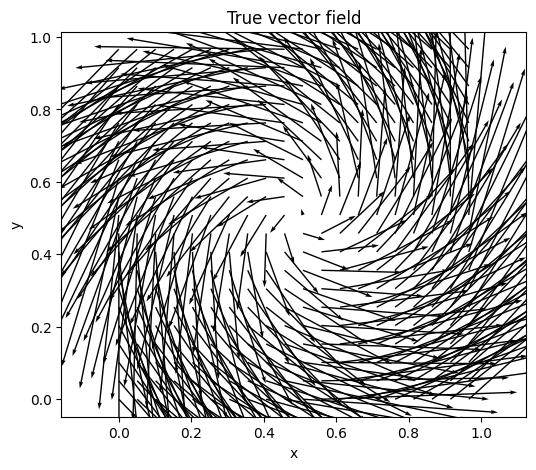

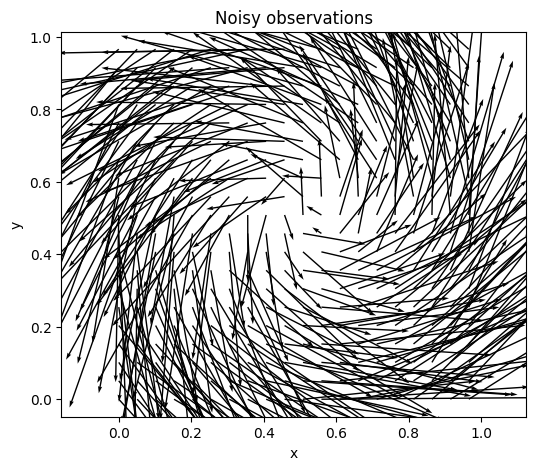

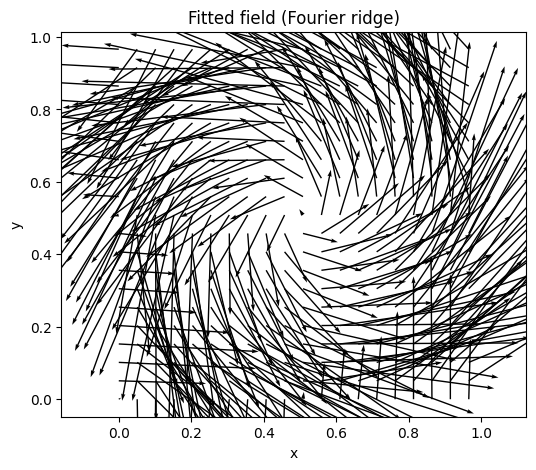

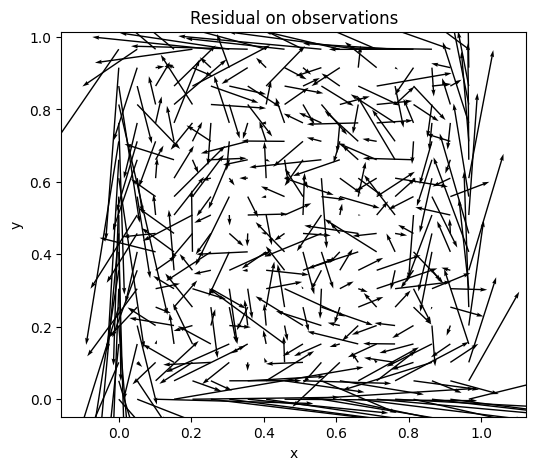

In [6]:

def quiver_plot(X, Y, U, V, title):
    plt.figure(figsize=(6,5))
    step = max(1, X.shape[0]//20)
    plt.quiver(X[::step,::step], Y[::step,::step], U[::step,::step], V[::step,::step], angles='xy', scale_units='xy', scale=1)
    plt.title(title)
    plt.xlabel('x'); plt.ylabel('y')
    plt.axis('equal')
    plt.show()

quiver_plot(X, Y, U_true, V_true, "True vector field")
quiver_plot(X, Y, U_noisy, V_noisy, "Noisy observations")
quiver_plot(X, Y, U_fit, V_fit, "Fitted field (Fourier ridge)")

res_u = U_noisy - U_fit
res_v = V_noisy - V_fit
quiver_plot(X, Y, res_u, res_v, "Residual on observations")


## 5. Simple API wrapper

`SmoothVFRegressor` exposes `fit` and `predict` for reuse with different bases and grids.


In [7]:

@dataclass
class SmoothVFRegressor:
    kmax: int = 3
    lam_u: Optional[float] = None
    lam_v: Optional[float] = None
    a_: Optional[np.ndarray] = None
    b_: Optional[np.ndarray] = None
    R_: Optional[np.ndarray] = None

    def _Phi(self, X, Y):
        return fourier_basis_2d(X, Y, kmax=self.kmax)

    def fit(self, X, Y, U, V, lambdas=None):
        Phi = self._Phi(X, Y)
        self.R_ = fourier_penalty(Phi, self.kmax)
        if lambdas is None:
            lambdas = np.logspace(-6, 1, 12)
        self.lam_u = grid_search_lambda(Phi, U.ravel(), self.R_, lambdas)
        self.lam_v = grid_search_lambda(Phi, V.ravel(), self.R_, lambdas)
        self.a_ = ridge_fit(Phi, U.ravel(), self.R_, self.lam_u)
        self.b_ = ridge_fit(Phi, V.ravel(), self.R_, self.lam_v)
        return self

    def predict(self, X, Y):
        Phi = self._Phi(X, Y)
        Uhat = (Phi @ self.a_).reshape(X.shape)
        Vhat = (Phi @ self.b_).reshape(Y.shape)
        return Uhat, Vhat

# quick test
model = SmoothVFRegressor(kmax=3).fit(X, Y, U_noisy, V_noisy)
U_hat, V_hat = model.predict(X, Y)
print("Relative L2 error on true U:", np.linalg.norm(U_hat-U_true)/np.linalg.norm(U_true))
print("Relative L2 error on true V:", np.linalg.norm(V_hat-V_true)/np.linalg.norm(V_true))


Relative L2 error on true U: 0.40876218478814436
Relative L2 error on true V: 0.40896198520355975


## 6. Extension stub: Helmholtz-type bases (gradient + stream)

You can enforce structure by modeling
$$\mathbf{F} = \nabla \phi + R\nabla \psi$$,
where $R$ rotates vectors by 90°. A simple approach is to expand $\phi$ and $\psi$ in the same Fourier basis, then assemble the induced vector basis. Below is a minimal stub.


In [8]:

def helmholtz_vector_basis(X, Y, kmax=3):
    """Return (Bx, By) where each has shape [npts, n_helm], concatenating
    gradient modes and stream modes. Coefficients map to u,v jointly."""
    x = X.ravel(); y = Y.ravel()
    Bx_list, By_list = [], []
    # scalar bases for potentials
    scalars = [np.ones_like(x)]
    k_tags = [(0,0)]
    for k in range(1, kmax+1):
        scalars += [np.cos(2*np.pi*k*x), np.sin(2*np.pi*k*x),
                    np.cos(2*np.pi*k*y), np.sin(2*np.pi*k*y)]
        k_tags += [(k,0), (k,0), (0,k), (0,k)]
    for kx in range(1, kmax+1):
        for ky in range(1, kmax+1):
            cx = np.cos(2*np.pi*kx*x); sx = np.sin(2*np.pi*kx*x)
            cy = np.cos(2*np.pi*ky*y); sy = np.sin(2*np.pi*ky*y)
            scalars += [cx*cy, cx*sy, sx*cy, sx*sy]
            k_tags += [(kx,ky)]*4
    # gradients
    for (kx,ky), s in zip(k_tags, scalars):
        if (kx,ky)==(0,0):
            gx = np.zeros_like(x); gy = np.zeros_like(y)
        else:
            # derivative of scalar Fourier mode
            # use central differences via analytic derivative
            if ky==0 and kx==0:
                gx = np.zeros_like(x); gy = np.zeros_like(y)
            else:
                # approximate derivative by using associated sine/cos pairs.
                # For robustness, compute numerically via small epsilon.
                eps = 1e-5
                # reshape temporarily for finite-diff
                n = int(np.sqrt(x.size))
                Xg = X; Yg = Y
                def s2d(Xg, Yg):
                    # map back from flat index to 2D evaluation
                    idx = 0
                    return s.reshape(Xg.shape)
                S = s.reshape(X.shape)
                # numerical grads
                dx = (np.roll(S, -1, axis=1) - np.roll(S, 1, axis=1)) / (2*(Xg[0,1]-Xg[0,0]))
                dy = (np.roll(S, -1, axis=0) - np.roll(S, 1, axis=0)) / (2*(Yg[1,0]-Yg[0,0]))
                gx = dx.ravel(); gy = dy.ravel()
        # gradient contribution for phi
        Bx_list.append(gx); By_list.append(gy)
        # stream contribution for psi: rotate (gx,gy) by +90° -> (-gy, gx)
        Bx_list.append(-gy); By_list.append(gx)
    Bx = np.stack(Bx_list, axis=1)
    By = np.stack(By_list, axis=1)
    return Bx, By

# Example construction (not used by default)
Bx, By = helmholtz_vector_basis(X, Y, kmax=2)
Bx.shape, By.shape


((3600, 50), (3600, 50))